In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(trainx, trainy), (testx, testy) = mnist.load_data()
trainy = np.reshape(trainy,(trainy.shape[0],1))
testy = np.reshape(testy,(testy.shape[0],1))
print('Train: X=%s, y=%s' % (trainx.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testy.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000, 1)
Test: X=(10000, 1), y=(10000, 1)


In [3]:
trainX = trainx.reshape(trainx.shape[0], -1).T
testX = testx.reshape(testx.shape[0], -1).T
trainY = trainy.reshape(trainy.shape[0], -1).T
testY = testy.reshape(testy.shape[0], -1).T
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

Train: X=(784, 60000), y=(1, 60000)
Test: X=(784, 10000), y=(1, 10000)


In [4]:
Y_train=np.zeros((10,trainY.shape[1]))
for i in range(trainY.shape[1]):
    Y_train[trainY[0,i],i]=1
Y_test=np.zeros((10,testY.shape[1]))
for i in range(testY.shape[1]):
    Y_test[testY[0,i],i]=1

In [5]:
trainX = trainX/255.0
testX = testX/255.0

In [6]:
def initialise_parameters(layers):
    L = len(layers)
    parameters = {}
    for i in range(1,L):
    
        parameters['W' + str(i)] = np.random.randn(layers[i],layers[i-1])*0.01
        parameters['b' + str(i)] = np.zeros((layers[i],1))
    
        assert(parameters['W' + str(i)].shape == (layers[i], layers[i-1]))
        assert(parameters['b' + str(i)].shape == (layers[i], 1))
    
    
    return parameters


In [26]:
parameter = initialise_parameters([5,4,3])

print("W1 = " + str(parameter["W1"]))
print("b1 = " + str(parameter["b1"]))
print("W2 = " + str(parameter["W2"]))
print("b2 = " + str(parameter["b2"]))

W1 = [[ 0.0009901   0.00409399 -0.00679245  0.00870781  0.00864838]
 [ 0.005338    0.01878665  0.00329248 -0.00375032  0.00149227]
 [ 0.00564289  0.00085941 -0.0120192   0.00615357  0.00134981]
 [ 0.00227357  0.00927041  0.01237818 -0.00100014  0.00081559]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.00278684 -0.01472199 -0.0046984  -0.00124308]
 [-0.02410826 -0.00799539 -0.00660379 -0.00315777]
 [-0.00643153 -0.0053861   0.01058869 -0.00171699]]
b2 = [[0.]
 [0.]
 [0.]]


In [27]:
def sigmoidf(x):

    z = 1/(1 + np.exp(-1*x))
    return z, x

In [28]:
def reluf(x):
    z = np.maximum(0,x)
    return z, x

In [29]:
def forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache
    

In [30]:
def activation(A_prev, W, b, actifunc):
    Z, linear = forward(A_prev, W, b)
    if actifunc == "sigmoid":
        A, activation_cache = sigmoidf(Z)
    elif actifunc == "relu":
        A, activation_cache = reluf(Z)
        
    cache = (linear, activation_cache)
    
    return A, cache

In [31]:
def forwardpropagation(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2
    
    for l in range(1,L):
        A_prev = A
        A, cache = activation(A_prev, parameters['W'+str(l)], parameters['b'+str(l)],actifunc = "relu")
        caches.append(cache)
    
    AL, cache = activation(A, parameters['W'+str(L)], parameters['b'+str(L)],actifunc = "sigmoid")
    caches.append(cache)
    
    
    return AL, caches
    

In [32]:
def calcost(AL, Y):
    m = Y.shape[1]
    #Af = convert(AL,Y)
    
    cost = -1/m*np.sum(np.multiply(Y, np.log(AL))+np.multiply(1-Y, np.log(1-AL)))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [33]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m*np.dot(dZ, A_prev.T)
    db = 1/m*np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [34]:
def drelu(dA, activation_cache):
    Z = activation_cache
    Z[Z<=0] = 0
    Z[Z>0] = 1
    dZ = np.multiply(dA,Z)
    return dZ

In [35]:
def dsigmoid(dA, activation_cache):
    Z = activation_cache
    gZ = np.exp(-1*Z)/(1+2*np.exp(-1*Z)+np.exp(-2*Z))
    dZ = np.multiply(dA, gZ)
    return dZ

In [36]:
def activation_backward(dA, cache, actifunc):
    linear_cache, activation_cache = cache
    
    if (actifunc == "relu"):
        dZ = drelu(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif (actifunc == "sigmoid"):
        dZ = dsigmoid(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [37]:
def model_backward(AL, Y, caches):
    #Af = convert(AL, Y)
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAl = -1*(np.divide(Y, AL)-np.divide(1-Y,1-AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = activation_backward(dAl, current_cache, "sigmoid")
    grads["dA"+str(L-1)] = dA_prev_temp
    grads["dW"+ str(L)] = dW_temp
    grads["db" +str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+ str(l+1)] = dW_temp
        grads["db" +str(l+1)] = db_temp
        
    return grads

In [38]:
def update_parameters(params, grads, learning_rate):
    
    parameters = params.copy()
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l + 1)]
        
    return parameters

In [39]:
n_x = trainX.shape[0]
n_y = 10
layer_dims = (n_x, 60, 10, n_y)

In [40]:
def model(X, Y, layer_dims, learning_rate = 0.005, num_iterations = 3000, print_cost = False):
    
    costs = []
    m = X.shape[1]
    
    parameters = initialise_parameters(layer_dims)
    
    for i in range(0, num_iterations):
        
        AL, caches = forwardpropagation(X, parameters)
        
        cost = calcost(AL, Y)
        
        grads = model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 1000 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 1000 == 0 or i == num_iterations:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
            
    return parameters, costs

Cost after iteration 0: 6.931528762579645
Cost after iteration 1000: 3.827156901333331
Cost after iteration 2000: 3.2566663134273224
Cost after iteration 3000: 3.2460709277671826
Cost after iteration 4000: 3.2235127903152216
Cost after iteration 5000: 3.1491478139315268
Cost after iteration 6000: 2.989623254310934
Cost after iteration 7000: 2.8687926201201566
Cost after iteration 8000: 2.7439698152643723
Cost after iteration 9000: 2.6419093922678782
Cost after iteration 10000: 2.5423861555790435
Cost after iteration 11000: 2.3855094949003144
Cost after iteration 12000: 2.1500813125542937
Cost after iteration 13000: 1.8690066952761788
Cost after iteration 14000: 1.6318567830874577
Cost after iteration 15000: 1.360144313079797
Cost after iteration 16000: 1.1878712578380721
Cost after iteration 17000: 1.0954831399302083
Cost after iteration 18000: 1.0272248914730473
Cost after iteration 19000: 0.9691215646926501
Cost after iteration 20000: 0.9172106066497531
Cost after iteration 21000: 0.

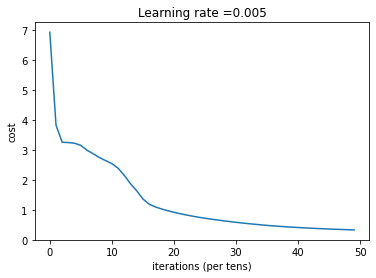

In [41]:
parameters, costs = model(trainX, Y_train, layer_dims, num_iterations = 50000, print_cost = True)

In [42]:
def predict(X, parameters):
    AL, caches = forwardpropagation(X, parameters)
    prediction=np.argmax(AL,axis=0)
    return prediction.reshape(1,prediction.shape[0])

In [43]:
predictions = predict(trainX, parameters)
print("Training Accuracy : "+ str(np.sum(predictions==trainY)/trainY.shape[1] * 100)+" %")

Training Accuracy : 95.565 %


In [44]:
predictions_test = predict(testX, parameters)
print("Testing Accuracy : "+ str(np.sum(predictions_test==testY)/testY.shape[1] * 100)+" %")

Testing Accuracy : 94.88 %
